In [544]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import datetime
import numpy as np
from datetime import date
from  time import sleep

from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import spotipy
import json
from spotipy.oauth2 import SpotifyClientCredentials

import warnings
warnings.filterwarnings("ignore")

from config import *
pd.set_option('display.max_columns', None)

import webbrowser
from IPython.core.display import display, HTML

In [263]:
def getting_df(url):
    '''web scraping from url'''
    response = requests.get(url)
    response.status_code # 200 status code means OK!
    soup = BeautifulSoup(response.content, "html.parser")
    artist = []
    song = []

    for tag in soup.select(".chart-element__information__artist"):
        artist.append(tag.get_text())

    for tag in soup.select(".chart-element__information__song"):
        song.append(tag.get_text())

    d = {'artist': artist, 'song': song}
    df = pd.DataFrame(d,columns = ['artist','song'])
    df.drop_duplicates(inplace=True)
    df['creation_ddbb'] = date.today()
    return df

In [264]:
def updating_df(url,df):
    '''updating with new web scraping from url'''
    response = requests.get(url)
    response.status_code # 200 status code means OK!
    soup = BeautifulSoup(response.content, "html.parser")
    new_artist = []
    new_song = []
    for tag in soup.select(".chart-element__information__artist"):
        new_artist.append(tag.get_text())
    for tag in soup.select(".chart-element__information__song"):
        new_song.append(tag.get_text().capitalize())
    for s in list(df.song):
        if s not in new_song:
            df.drop(list(df[df.song == s].index))
    for s in new_song:
        if s not in list(df.song):
            new_row = {'artist': new_artist[new_song.index(s)] ,'song': s,'creation_ddbb': date.today()}
            df = df.append(new_row, ignore_index=True)
    df.to_csv('billboard_music_db.csv', index=False)
    return df
# second url to try: https://www.billboard.com/charts/billboard-200


In [259]:
df = pd.read_csv('billboard_music_db.csv')
df.head()

,artist,song,creation_ddbb
0,Olivia Rodrigo,Drivers license,2021-02-22
1,Cardi B,Up,2021-02-22
2,The Weeknd,Blinding lights,2021-02-22
3,The Weeknd,Save your tears,2021-02-22
4,24kGoldn Featuring iann dior,Mood,2021-02-22


Lab | API wrappers - Create your collection of songs & audio features

Instructions
To move forward with the project, you need to create a collection of songs with their audio features - as large as possible!

These are the songs that we will cluster. And, later, when the user inputs a song, we will find the cluster to which the song belongs and recommend a song from the same cluster. The more songs you have, the more accurate and diverse recommendations you'll be able to give. Although... you might want to make sure the collected songs are "curated" in a certain way. Try to find playlists of songs that are diverse, but also that meet certain standards.

The process of sending hundreds or thousands of requests can take some time - it's normal if you have to wait a few minutes (or, if you're ambitious, even hours) to get all the data you need.

An idea for collecting as many songs as possible is to start with all the songs of a big, diverse playlist and then go to every artist present in the playlist and grab every song of every album of that artist. The amount of songs you'll be collecting per playlist will grow exponentially!

In [563]:
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id= spotify_client_id,
                                                           client_secret= spotify_client_secret))

In [564]:
def get_playlist_tracks(username, playlist_id):
    '''return songs from playlist'''
    results = sp.user_playlist_tracks(username,playlist_id)
    tracks = results['items']
    while results['next']:
        results = sp.next(results)
        tracks.extend(results['items'])
    return tracks

In [574]:
# extract song names and artists from playlist
def song_artist(username, playlist_id):
    '''return artist's songs from songs from playlist'''
    song_artist_dict = {}
    playlist_tracks = get_playlist_tracks(username, playlist_id)
    playlist_len = len(playlist_tracks)
    
    for i in range(playlist_len):
        song_name = playlist_tracks[i]['track']['name']
        song_id = playlist_tracks[i]['track']['id']
        singer = playlist_tracks[i]['track']['artists'][0]['name']
        song_artist_dict[singer] = {'song_name':song_name,'song_id':song_id}
        sleep(1)
    return song_artist_dict

In [575]:
def database_songs(song_artist_dict):
    '''returns a music database'''
    dict_songs = {}
    for artist in song_artist_dict.keys():
        songs = sp.search(q=artist,limit=50)
        for i in range(50):
            try:
                song_id = songs["tracks"]["items"][i]['id']
                song = songs["tracks"]["items"][i]['name'].capitalize()
                song_choosen = sp.search(q=song)
                features = sp.audio_features(song_choosen["tracks"]["items"][0]["uri"])[0]
                #if song not in dict_songs.keys():
                features['artist'] = artist
                features['song_id'] = song_id
                dict_songs[song] = features
            except:
                break
            sleep(1)
    df = pd.DataFrame(dict_songs)
    df = df.T
    df['play_the_song'] = list(map(lambda x : 'https://open.spotify.com/embed/track/'+x[14:],df['uri']))
    df.to_csv('spoify_db.csv')
    return df
            

In [576]:
song_artist_dict = song_artist("spotify", "5Rrf7mqN8uus2AaQQQNdc1")

In [577]:
data = database_songs(song_artist_dict)
data.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,artist,song_id,play_the_song
Bob dylan,0.494,0.915,9,-3.623,1,0.0484,0.000353,0.0491,0.352,0.522,100.08,audio_features,3liDoBAc3NGI8tmWUTOAed,spotify:track:3liDoBAc3NGI8tmWUTOAed,https://api.spotify.com/v1/tracks/3liDoBAc3NGI...,https://api.spotify.com/v1/audio-analysis/3liD...,193040,4,Bob Dylan,09bH2kOPOfgYRB9IxDh9iw,https://open.spotify.com/embed/track/3liDoBAc3...
Like a rolling stone,0.483,0.721,0,-6.836,1,0.032,0.729,0,0.189,0.562,95.261,audio_features,3AhXZa8sUQht0UEdBJgpGc,spotify:track:3AhXZa8sUQht0UEdBJgpGc,https://api.spotify.com/v1/tracks/3AhXZa8sUQht...,https://api.spotify.com/v1/audio-analysis/3AhX...,369600,4,The Band,3AhXZa8sUQht0UEdBJgpGc,https://open.spotify.com/embed/track/3AhXZa8sU...
Knockin' on heaven's door,0.496,0.739,6,-7.193,1,0.0415,0.0211,0.00444,0.106,0.378,132.41,audio_features,4JiEyzf0Md7KEFFGWDDdCr,spotify:track:4JiEyzf0Md7KEFFGWDDdCr,https://api.spotify.com/v1/tracks/4JiEyzf0Md7K...,https://api.spotify.com/v1/audio-analysis/4JiE...,336000,4,Guns N' Roses,4JiEyzf0Md7KEFFGWDDdCr,https://open.spotify.com/embed/track/4JiEyzf0M...
"Don't think twice, it's all right",0.6,0.243,4,-17.085,1,0.0366,0.89,0.0022,0.249,0.468,110.535,audio_features,2WOjLF83vqjit2Zh4B69V3,spotify:track:2WOjLF83vqjit2Zh4B69V3,https://api.spotify.com/v1/tracks/2WOjLF83vqji...,https://api.spotify.com/v1/audio-analysis/2WOj...,217400,4,Bob Dylan,2WOjLF83vqjit2Zh4B69V3,https://open.spotify.com/embed/track/2WOjLF83v...
The times they are a-changin',0.389,0.396,7,-7.999,1,0.0332,0.887,0,0.0828,0.585,171.86,audio_features,52vA3CYKZqZVdQnzRrdZt6,spotify:track:52vA3CYKZqZVdQnzRrdZt6,https://api.spotify.com/v1/tracks/52vA3CYKZqZV...,https://api.spotify.com/v1/audio-analysis/52vA...,192053,3,Simon & Garfunkel,3sO5oZ9NLbAlU6h1qVCPJq,https://open.spotify.com/embed/track/52vA3CYKZ...


In [579]:
numerical = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms',
       'time_signature']

for i in numerical:
    data[i] = pd.to_numeric(data[i])

In [658]:
data_num = data.select_dtypes(np.number)
X_prep = StandardScaler().fit_transform(data_num)
X_prep = pd.DataFrame(X_prep, columns=data_num.columns)

In [659]:
kmeans = KMeans(n_clusters=5,
                init="random", 
                n_init=3,  # try with 1, 4, 8, 20, 30, 100...
                max_iter=2,
                tol=0,
                algorithm="full",
                random_state=1234)
kmeans.fit(X_prep)
print(kmeans.inertia_)

107081.33147535083


In [660]:
clusters = kmeans.predict(X_prep)
pd.Series(clusters).value_counts().sort_index()

0     823
1    3571
2    2532
3    1306
4    2166
dtype: int64

Text(0.5, 1.0, 'Elbow Method showing the optimal k')

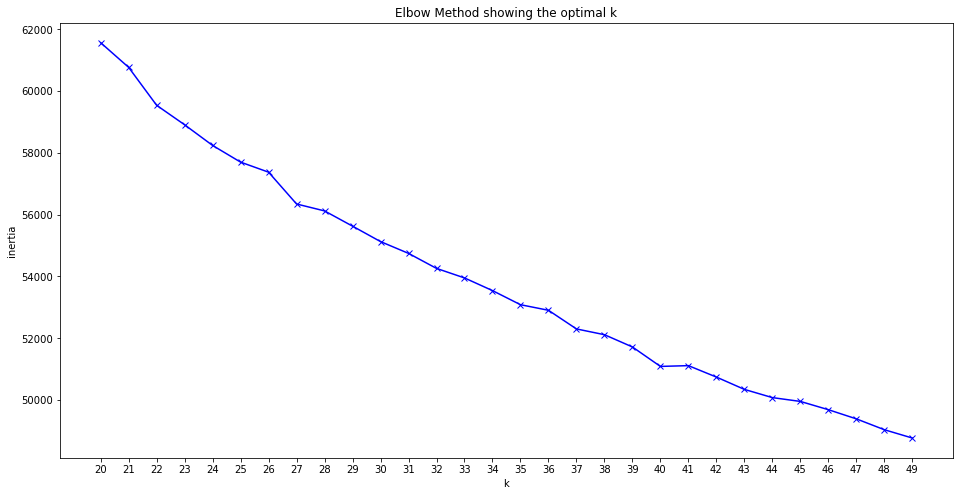

In [661]:
K = range(20, 50)
inertia = []

for k in K:
    kmeans = KMeans(n_clusters=k,
                    random_state=1234)
    kmeans.fit(X_prep)
    inertia.append(kmeans.inertia_)

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Elbow Method showing the optimal k')

Text(0.5, 1.0, 'Silhouette Method showing the optimal k')

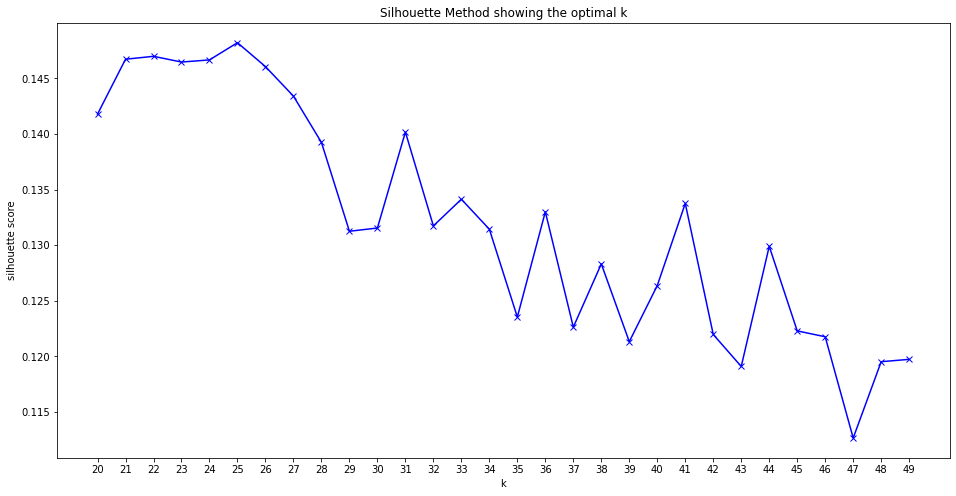

In [662]:
K = range(20, 50)
silhouette = []

for k in K:
    kmeans = KMeans(n_clusters=k,
                    random_state=1234)
    kmeans.fit(X_prep)
    silhouette.append(silhouette_score(X_prep, kmeans.predict(X_prep)))


plt.figure(figsize=(16,8))
plt.plot(K, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Silhouette Method showing the optimal k')

In [663]:
# TEST 2
kmeans = KMeans(n_clusters=50,
                n_init=20,  # try with 1, 4, 8, 20, 30, 100...
                max_iter=20,
                tol=0,
                algorithm="full",
                random_state=1234)
kmeans.fit(X_prep)
print(kmeans.inertia_)

48441.6265991757


Text(0.5, 1.0, 'Elbow Method showing the optimal k')

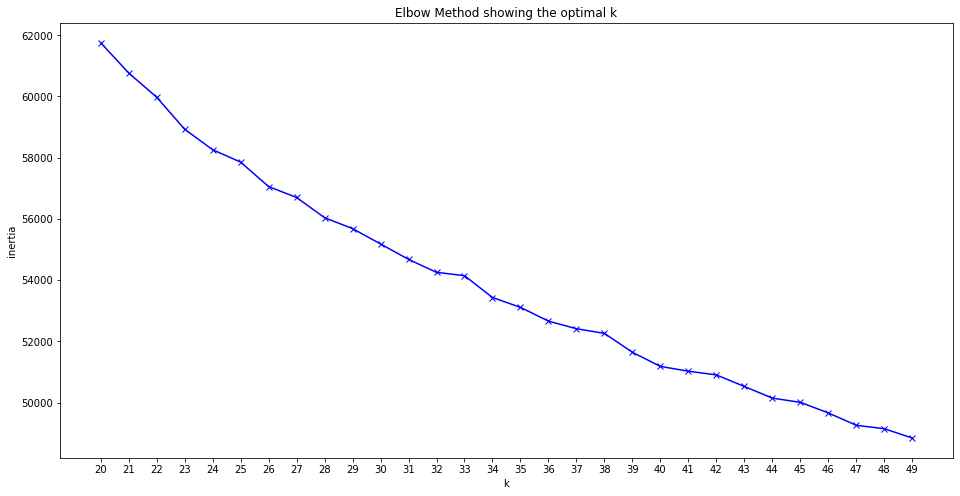

In [664]:
# TEST 2
K = range(20, 50)
inertia = []

for k in K:
    kmeans = KMeans(n_clusters=k,
                n_init=20,  # try with 1, 4, 8, 20, 30, 100...
                max_iter=20,
                tol=0,
                algorithm="full",
                random_state=1234)
    kmeans.fit(X_prep)
    inertia.append(kmeans.inertia_)

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Elbow Method showing the optimal k')

Text(0.5, 1.0, 'Silhouette Method showing the optimal k')

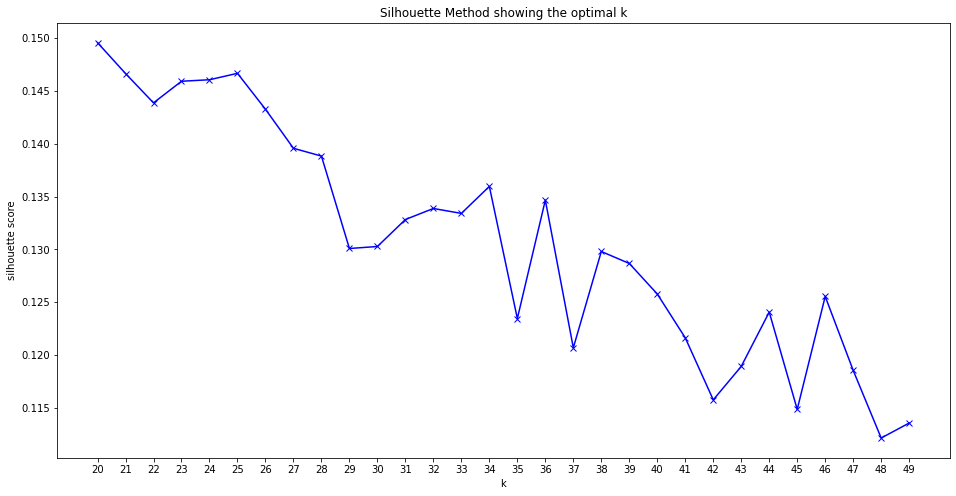

In [665]:
# TEST 2
K = range(20, 50)
silhouette = []

for k in K:
    kmeans = KMeans(n_clusters=k,
                n_init=20,  # try with 1, 4, 8, 20, 30, 100...
                max_iter=20,
                tol=0,
                random_state=1234)
    kmeans.fit(X_prep)
    silhouette.append(silhouette_score(X_prep, kmeans.predict(X_prep)))

plt.figure(figsize=(16,8))
plt.plot(K, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Silhouette Method showing the optimal k')

In [666]:
# I choose 24

In [667]:
# first thing morning
model = KMeans(n_clusters=24, random_state=0).fit(X_prep)
# fit model and predict clusters
yhat = model.fit_predict(X_prep)

In [668]:
# retrieve unique clusters
clusters = np.unique(yhat)
clusters

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23], dtype=int32)

In [669]:
yhat

array([ 1, 22, 22, ..., 22,  1, 20], dtype=int32)

In [670]:
X_prep

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,cluster
0,-0.433123,1.309620,1.056099,1.251068,0.632477,-0.298561,-1.009948,-0.176174,0.827711,-0.167938,-0.713819,-0.423981,0.245217,0.675291
1,-0.499966,0.485807,-1.460692,0.537740,0.632477,-0.498256,1.341563,-0.388635,-0.073073,-0.010353,-0.878040,1.574948,0.245217,1.118420
2,-0.420969,0.562243,0.217169,0.458482,0.632477,-0.382579,-0.942992,-0.369422,-0.531754,-0.735242,0.387914,1.194545,0.245217,1.118420
3,0.211003,-1.544001,-0.342118,-1.737670,0.632477,-0.442244,1.861147,-0.379115,0.258504,-0.380677,-0.357536,-0.148189,0.245217,-0.358677
4,-1.071172,-0.894293,0.496812,0.279539,0.632477,-0.483644,1.851465,-0.388635,-0.659963,0.080258,1.732280,-0.435156,-2.314793,1.709258
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10393,-0.894949,-0.083219,-1.460692,-0.077458,0.632477,-0.556704,-0.830685,-0.388605,-0.814699,-0.309764,-0.489417,1.875795,0.245217,-0.654096
10394,0.065163,0.553750,-0.342118,1.366070,-1.581086,0.287130,-0.931052,-0.386103,-0.836804,-2.075105,-0.539307,-0.231097,-7.434815,0.084452
10395,-0.354126,1.173734,-1.460692,1.266608,0.632477,-0.371620,-1.004342,-0.069727,-0.715226,-0.703725,-0.611790,0.174101,0.245217,1.118420
10396,-0.427046,1.254416,0.776456,1.045706,0.632477,-0.405715,-0.998275,-0.388630,1.070867,0.005405,-1.056914,-0.377031,0.245217,0.675291


In [671]:
# Merge cluster with original data
data['cluster'] = yhat
data

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,artist,song_id,play_the_song,cluster
Bob dylan,0.494,0.915,9,-3.623,1,0.0484,0.000353,0.049100,0.3520,0.5220,100.080,audio_features,3liDoBAc3NGI8tmWUTOAed,spotify:track:3liDoBAc3NGI8tmWUTOAed,https://api.spotify.com/v1/tracks/3liDoBAc3NGI...,https://api.spotify.com/v1/audio-analysis/3liD...,193040,4,Bob Dylan,09bH2kOPOfgYRB9IxDh9iw,https://open.spotify.com/embed/track/3liDoBAc3...,1
Like a rolling stone,0.483,0.721,0,-6.836,1,0.0320,0.729000,0.000000,0.1890,0.5620,95.261,audio_features,3AhXZa8sUQht0UEdBJgpGc,spotify:track:3AhXZa8sUQht0UEdBJgpGc,https://api.spotify.com/v1/tracks/3AhXZa8sUQht...,https://api.spotify.com/v1/audio-analysis/3AhX...,369600,4,The Band,3AhXZa8sUQht0UEdBJgpGc,https://open.spotify.com/embed/track/3AhXZa8sU...,22
Knockin' on heaven's door,0.496,0.739,6,-7.193,1,0.0415,0.021100,0.004440,0.1060,0.3780,132.410,audio_features,4JiEyzf0Md7KEFFGWDDdCr,spotify:track:4JiEyzf0Md7KEFFGWDDdCr,https://api.spotify.com/v1/tracks/4JiEyzf0Md7K...,https://api.spotify.com/v1/audio-analysis/4JiE...,336000,4,Guns N' Roses,4JiEyzf0Md7KEFFGWDDdCr,https://open.spotify.com/embed/track/4JiEyzf0M...,22
"Don't think twice, it's all right",0.600,0.243,4,-17.085,1,0.0366,0.890000,0.002200,0.2490,0.4680,110.535,audio_features,2WOjLF83vqjit2Zh4B69V3,spotify:track:2WOjLF83vqjit2Zh4B69V3,https://api.spotify.com/v1/tracks/2WOjLF83vqji...,https://api.spotify.com/v1/audio-analysis/2WOj...,217400,4,Bob Dylan,2WOjLF83vqjit2Zh4B69V3,https://open.spotify.com/embed/track/2WOjLF83v...,20
The times they are a-changin',0.389,0.396,7,-7.999,1,0.0332,0.887000,0.000000,0.0828,0.5850,171.860,audio_features,52vA3CYKZqZVdQnzRrdZt6,spotify:track:52vA3CYKZqZVdQnzRrdZt6,https://api.spotify.com/v1/tracks/52vA3CYKZqZV...,https://api.spotify.com/v1/audio-analysis/52vA...,192053,3,Simon & Garfunkel,3sO5oZ9NLbAlU6h1qVCPJq,https://open.spotify.com/embed/track/52vA3CYKZ...,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
A man i'll never be,0.418,0.587,0,-9.607,1,0.0272,0.055900,0.000007,0.0548,0.4860,106.665,audio_features,0bjKbwEvZfU5epyZ3aZm1y,spotify:track:0bjKbwEvZfU5epyZ3aZm1y,https://api.spotify.com/v1/tracks/0bjKbwEvZfU5...,https://api.spotify.com/v1/audio-analysis/0bjK...,396173,4,Boston,0bjKbwEvZfU5epyZ3aZm1y,https://open.spotify.com/embed/track/0bjKbwEvZ...,19
Driving me crazy,0.576,0.737,4,-3.105,0,0.0965,0.024800,0.000585,0.0508,0.0379,105.201,audio_features,27qtJxcgAQXyG7Uxccj9Qe,spotify:track:27qtJxcgAQXyG7Uxccj9Qe,https://api.spotify.com/v1/tracks/27qtJxcgAQXy...,https://api.spotify.com/v1/audio-analysis/27qt...,210077,1,Boston,2KQGs6oyLQwfqSZ5Zs0eje,https://open.spotify.com/embed/track/27qtJxcgA...,12
Plasticine dreams,0.507,0.883,0,-3.553,1,0.0424,0.002090,0.073700,0.0728,0.3860,103.074,audio_features,6ZjESxiylxtxe9cdg9wyIF,spotify:track:6ZjESxiylxtxe9cdg9wyIF,https://api.spotify.com/v1/tracks/6ZjESxiylxtx...,https://api.spotify.com/v1/audio-analysis/6ZjE...,245867,4,Boston,6ZjESxiylxtxe9cdg9wyIF,https://open.spotify.com/embed/track/6ZjESxiyl...,22
Laika,0.495,0.902,8,-4.548,1,0.0396,0.003970,0.000001,0.3960,0.5660,90.012,audio_features,78BbIbE1ZaFTk1gmYJEhiD,spotify:track:78BbIbE1ZaFTk1gmYJEhiD,https://api.spotify.com/v1/tracks/78BbIbE1ZaFT...,https://api.spotify.com/v1/audio-analysis/78Bb...,197187,4,Boston,78BbIbE1ZaFTk1gmYJEhiD,https://open.spotify.com/embed/track/78BbIbE1Z...,1


In [674]:
def return_a_new_song(customer_song,df,data):
    '''returns a recommended song'''
    customer_song = customer_song.capitalize()
    if customer_song in list(df.song):
        artist_customer = df[df.song == customer_song].artist.item()
        if len(df[df.artist == artist_customer]) > 1:
            customer_song_ = df[df.song == customer_song].song.item()
            results = df[df.artist == artist_customer]

            saved_song = results[results.song != customer_song].sample(1)
            print("")
            print("")
            print("We recommend you this song: {} from {}".format(saved_song['song'].values[0], saved_song['artist'].values[0]))
            print("")
            print('Listen to it on this link: ',webbrowser.open('https://open.spotify.com/embed/track/'+sp.search(q=saved_song['song'].values[0], limit= 1)['tracks']['items'][0]['uri'][14:],new=1))

        else:
            saved_song = df.sample(1)
            print("")
            print("")
            print("We recommend you this song: {} from {}".format(saved_song['song'].values[0], saved_song['artist'].values[0]))
            print("")
            try:
                sp.search(q=saved_song['song'].values[0], limit= 1)['tracks']['items'][0]['uri']
                print('Listen to it on this link: ',webbrowser.open('https://open.spotify.com/embed/track/'+ sp.search(q=saved_song['song'].values[0], limit= 1)['tracks']['items'][0]['uri'][14:],new=1))
            except:
                link = data[data['song'] == customer_song]['play_the_song'].values[0]
                print('Listen to it on this link: ',webbrowser.open(link, new=1))
                
    elif customer_song in list(data.index):
        cluster = data.loc[customer_song]['cluster']
        
        chunk_cluster_data = data[data['cluster'] == cluster]
        chunk_cluster_data = chunk_cluster_data.drop(customer_song)
        
        pick_up_song = chunk_cluster_data.sample(1)

        song_name = pick_up_song.index.values[0]
        artist_name = pick_up_song[['artist']].values[0]
        link = pick_up_song['play_the_song'].values[0]

        print("")
        print("")
        print('We recommend you this song: {} from {}'.format(song_name,artist_name))
        print("")
        print('Listen to it on this link: ',webbrowser.open(link, new=1))
    else:
        print("We couldn't find a song called {}. Plase provide another song".format(customer_song))
        return return_a_new_song(input("Choose another song: "),df,data) 

In [675]:
def display_song():
    ''' returns a recommended song'''
    display(HTML('<h1>Welcome to Focus break time game!</h1>'))
    sleep(1)
    customer_song = input('Choose a song: ')
    return return_a_new_song(customer_song,df,data) 

#### Demo options:

* We have two databases created to access songs: Billboard database and  spotify database.
    * If the song is in the Billboard database it will return a hot song from that database.
    * If the song is not in the Billboard database it will return a song from the spotify database.

1. Same singer song recommendation from Billboard database when the artist appears more than once. E.g. Save YOUR TEARS

2. Random song recommendation from Billboard database when the artist has just one song there. E.g. DriVERS license

3. Song Recommendation based on a cluster approach. E.g. say my name

4. Option to write another song when it doesn't exist on the databases.

In [681]:
display_song()

Choose a song: Don't think twice, it's all right


We recommend you this song: Morning morgantown from ['Joni Mitchell']

Listen to it on this link:  True
